# 3.2 线性回归的从零开始实现

### 3.2.1 生成数据集

为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。 在下面的代码中，我们生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。

我们使用线性模型参数 $w=[2, -3.4]^\top、b=4.2$、 和噪声项 $\epsilon$ 生成数据集及其标签：

$$y=Xw+b+\epsilon$$

你可以将 $\epsilon$ 视为模型预测和标签时的潜在观测误差。 在这里我们认为标准假设成立，即 $\epsilon$ 服从均值为0的正态分布。 为了简化问题，我们将标准差设为0.01。 下面的代码生成合成数据集。

In [2]:
import random
import mindspore as ms
import mindspore.ops as ops
from mindspore import Tensor

def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = ops.normal((num_examples, len(w)), Tensor(0, ms.int32), Tensor(1, ms.int32))
    y = ops.matmul(X, w) + b
    y += ops.normal(y.shape, Tensor(0, ms.int32), Tensor(0.01, ms.float32))
    return X, y.reshape((-1, 1))

true_w = Tensor([2, -3.4], ms.float32)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）。

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: [ 0.36666957 -0.73936903] 
label: [7.4508605]


通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。

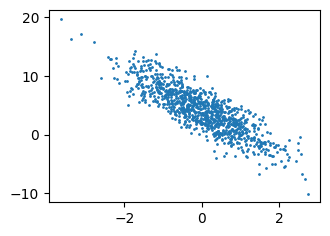

In [4]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (3.5, 2.5)
plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1)

### 3.2.2 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = Tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[ 0.54792863  0.42348784]
 [-0.9227124   0.7702285 ]
 [-1.1201844  -0.43689227]
 [-0.15301192  1.5280643 ]
 [ 0.5209222  -0.0725368 ]
 [-1.1853285  -1.1620319 ]
 [ 1.4099958   0.77902794]
 [-1.0082736  -1.5323331 ]
 [-0.04559258  0.08245143]
 [ 1.3008995  -1.0296667 ]] 
 [[ 3.8586838 ]
 [-0.24199226]
 [ 3.433836  ]
 [-1.3013812 ]
 [ 5.4944253 ]
 [ 5.794819  ]
 [ 4.3703175 ]
 [ 7.3958735 ]
 [ 3.8195162 ]
 [10.298698  ]]


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

---

在我们开始用小批量随机梯度下降优化我们的模型参数之前，先简单介绍下MindSpore的动静态图。

目前主流的深度学习框架有静态图(Graph)和动态图(PyNative)两种执行模式。

静态图模式下，程序在编译执行时，首先生成神经网络的图结构，然后再执行图中涉及的计算操作。因此，在静态图模式下，编译器可以通过使用图优化等技术来获得更好的执行性能，有助于规模部署和跨平台运行。

动态图模式下，程序按照代码的编写顺序逐行执行，在执行正向过程中根据反向传播的原理，动态生成反向执行图。这种模式下，编译器将神经网络中的各个算子逐一下发到设备进行计算操作，方便用户编写和调试神经网络模型。

MindSpore提供了静态图和动态图统一的编码方式，静态图模式是MindSpore的默认模式，而动态图模式用于调试等用途。

MindSpore的静态图思路是将整个模型视作一个完整的计算图，即模型、Loss、优化器均需要作为计算图的一部分，与PyTorch的使用习惯有些不同。


#### （1）定义模型、定义模型的参数

从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [7]:
import mindspore.nn as nn
from mindspore import Parameter
from mindspore.common.initializer import initializer, Zero, Normal

class Net(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = Parameter(initializer(Normal(0.01, 0), (2, 1), ms.float32))
        self.b = Parameter(initializer(Zero(), 1, ms.float32))
    
    def linreg(self, x, w, b):
        """线性回归模型"""
        return ops.matmul(x, w) + b 

    def construct(self, x):
        y_hat = self.linreg(x, self.w, self.b)
        return y_hat

#### （2）定义损失函数

In [8]:
class SquaredLoss(nn.Cell):
    """自定义损失函数SquaredLoss"""

    def __init__(self):
        """初始化"""
        super(SquaredLoss, self).__init__()

    def construct(self, y_hat, y):
        loss = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
        return loss


#### （3）定义 SGD 优化算法

自定义优化器时需继承优化器基类 `nn.Optimizer`，并重写 `__init__` 方法和 `construct` 方法以自行设定参数更新策略。

In [9]:
class SGD(nn.Optimizer):
    """定义优化器"""
    def __init__(self, params, lr, batch_size):
        super(SGD, self).__init__(lr, params, batch_size)
        self.lr = lr
        self.params = params
        self.batch_size = batch_size
        self.assign = ops.Assign()

    def construct(self, gradients):
        """construct输入为梯度，在训练中自动传入梯度gradients"""
        for i in range(len(self.params)):
            self.assign(self.params[i], self.params[i] - self.lr * gradients[i] / self.batch_size)
            # ops.Assign的作用是为网络参数赋值，因为静态图无法直接使用 w = w - lr*grads 来更新权重。
        return self.params

#### （4）定义训练过程

正向传播计算结果-->反向传播计算梯度-->更新权重

In [10]:
class TrainOneStepCell(nn.Cell):
    def __init__(self, network, optimizer):
        super().__init__()
        self.network = network
        self.optimizer = optimizer
        self.grad = ops.GradOperation(get_by_list=True)
        
    def construct(self, x, y):
        loss = self.network(x, y)
        grads = self.grad(self.network, self.optimizer.parameters)(x, y)
        self.optimizer(grads)
        return loss

In [11]:
lr = 0.01
num_epochs = 10
# 实例化前向网络
net = Net()
# 设定损失函数并连接前向网络与损失函数
loss = SquaredLoss()
# 连接前向网络与损失函数
net_with_loss = nn.WithLossCell(net, loss)
# 设定优化器
optimer = SGD(net.trainable_params(), lr, batch_size)
# 定义训练网络，封装网络和优化器
train = TrainOneStepCell(net_with_loss, optimer)
train.set_train()

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, features, labels):
        l = train(x, y)
    train_l = net_with_loss(features, labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean().asnumpy()):f}')

epoch 1, loss 2.227204
epoch 2, loss 0.300489
epoch 3, loss 0.040628
epoch 4, loss 0.005545
epoch 5, loss 0.000791
epoch 6, loss 0.000148
epoch 7, loss 0.000061
epoch 8, loss 0.000049
epoch 9, loss 0.000048
epoch 10, loss 0.000047


通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近。

In [12]:
print(f'w的估计误差: {true_w - net.trainable_params()[0].reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - net.trainable_params()[1]}')

w的估计误差: [-0.00027752 -0.00070596]
b的估计误差: [0.00053358]
